# House price

In [52]:
!pip install catboost

                                              0.0/101.0 MB ? eta -:--:--
                                            0.0/101.0 MB 435.7 kB/s eta 0:03:52
                                            0.1/101.0 MB 656.4 kB/s eta 0:02:34
                                              0.2/101.0 MB 1.2 MB/s eta 0:01:27
                                              0.3/101.0 MB 1.8 MB/s eta 0:00:57
                                              0.5/101.0 MB 2.3 MB/s eta 0:00:44
                                              0.9/101.0 MB 3.4 MB/s eta 0:00:30
                                              1.8/101.0 MB 5.7 MB/s eta 0:00:18
     -                                        2.8/101.0 MB 7.9 MB/s eta 0:00:13
     -                                        3.8/101.0 MB 9.6 MB/s eta 0:00:11
     --                                      5.4/101.0 MB 12.3 MB/s eta 0:00:08
     --                                      5.7/101.0 MB 12.2 MB/s eta 0:00:08
     --                                      5.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostRegressor

# from pycaret.regression import setup, compare_models

## 导入数据

In [2]:
train0 = pd.read_csv('house_prices/train.csv')
test0 = pd.read_csv('house_prices/test.csv')

In [3]:
train0.shape

(1460, 81)

In [4]:
test0.shape

(1459, 80)

#### 设置out显示

In [5]:
# 设置显示全部out信息窗口
from IPython.display import display, HTML


def show_all_tables(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html +='</div>'
    return html

In [6]:
# 查看每一列的统计描述信息
display(HTML(show_all_tables(train0.describe(), train0, 'describe_info')))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# 显示有空值的列,并观察其缺失数量和类型
train_null_cols = train0.isnull().sum()[train0.isnull().sum() > 0]
train_null_cols_dtypes = train0[train_null_cols.index].dtypes

# 将它们合并为一个数据框
train_null_cols_info = pd.concat([train_null_cols, train_null_cols_dtypes], axis=1)

train_null_cols_info = train_null_cols_info.rename(columns={0: 'Missing counts', 1: 'Data type'})

train_null_cols_info

,Missing counts,Data type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


### 将训练集和测试集合并，用以填充缺失值

In [8]:
# 保留列属性
target = train0['SalePrice']
test_ids = test0['Id']

# 删除无用列
train1 = train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop(['Id'], axis=1)

# 合并
data1 = pd.concat([train1,test1], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [9]:
target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

### 清理数据

In [10]:
# 查看不同数据类型
display(HTML(show_all_tables(data1.select_dtypes(np.number).head(), data1, 'num_info')))

display(HTML(show_all_tables(data1.select_dtypes(include=[object]).head(), data1, 'object_info')))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [11]:
data2 = data1.copy()
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

In [12]:
# 查看object列的缺失情况
data2.select_dtypes('object').isnull().sum()[data2.select_dtypes('object').isnull().sum() > 0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

#### 对非数值型数据进行分类填充

In [13]:
# 根据data_description文档，一一查看缺失列的具体情况，如果NA有具体含义，则赋予值替代；如果确认为空值，用众数mean替代

# NA有具体含义,用None替代
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")
    
# 缺失值没有意义，用众数mean替代
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [14]:
data2.select_dtypes('object').isnull().sum()[data2.select_dtypes('object').isnull().sum() > 0]

Series([], dtype: int64)

#### 对数值数据进行简单相关性分析，用以衡量如何填充空值

In [15]:
data2.select_dtypes(np.number).isnull().sum()[data2.select_dtypes(np.number).isnull().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [16]:
check_related = data2.select_dtypes(include=[np.number])
check_related.shape

(2919, 35)

<Axes: >

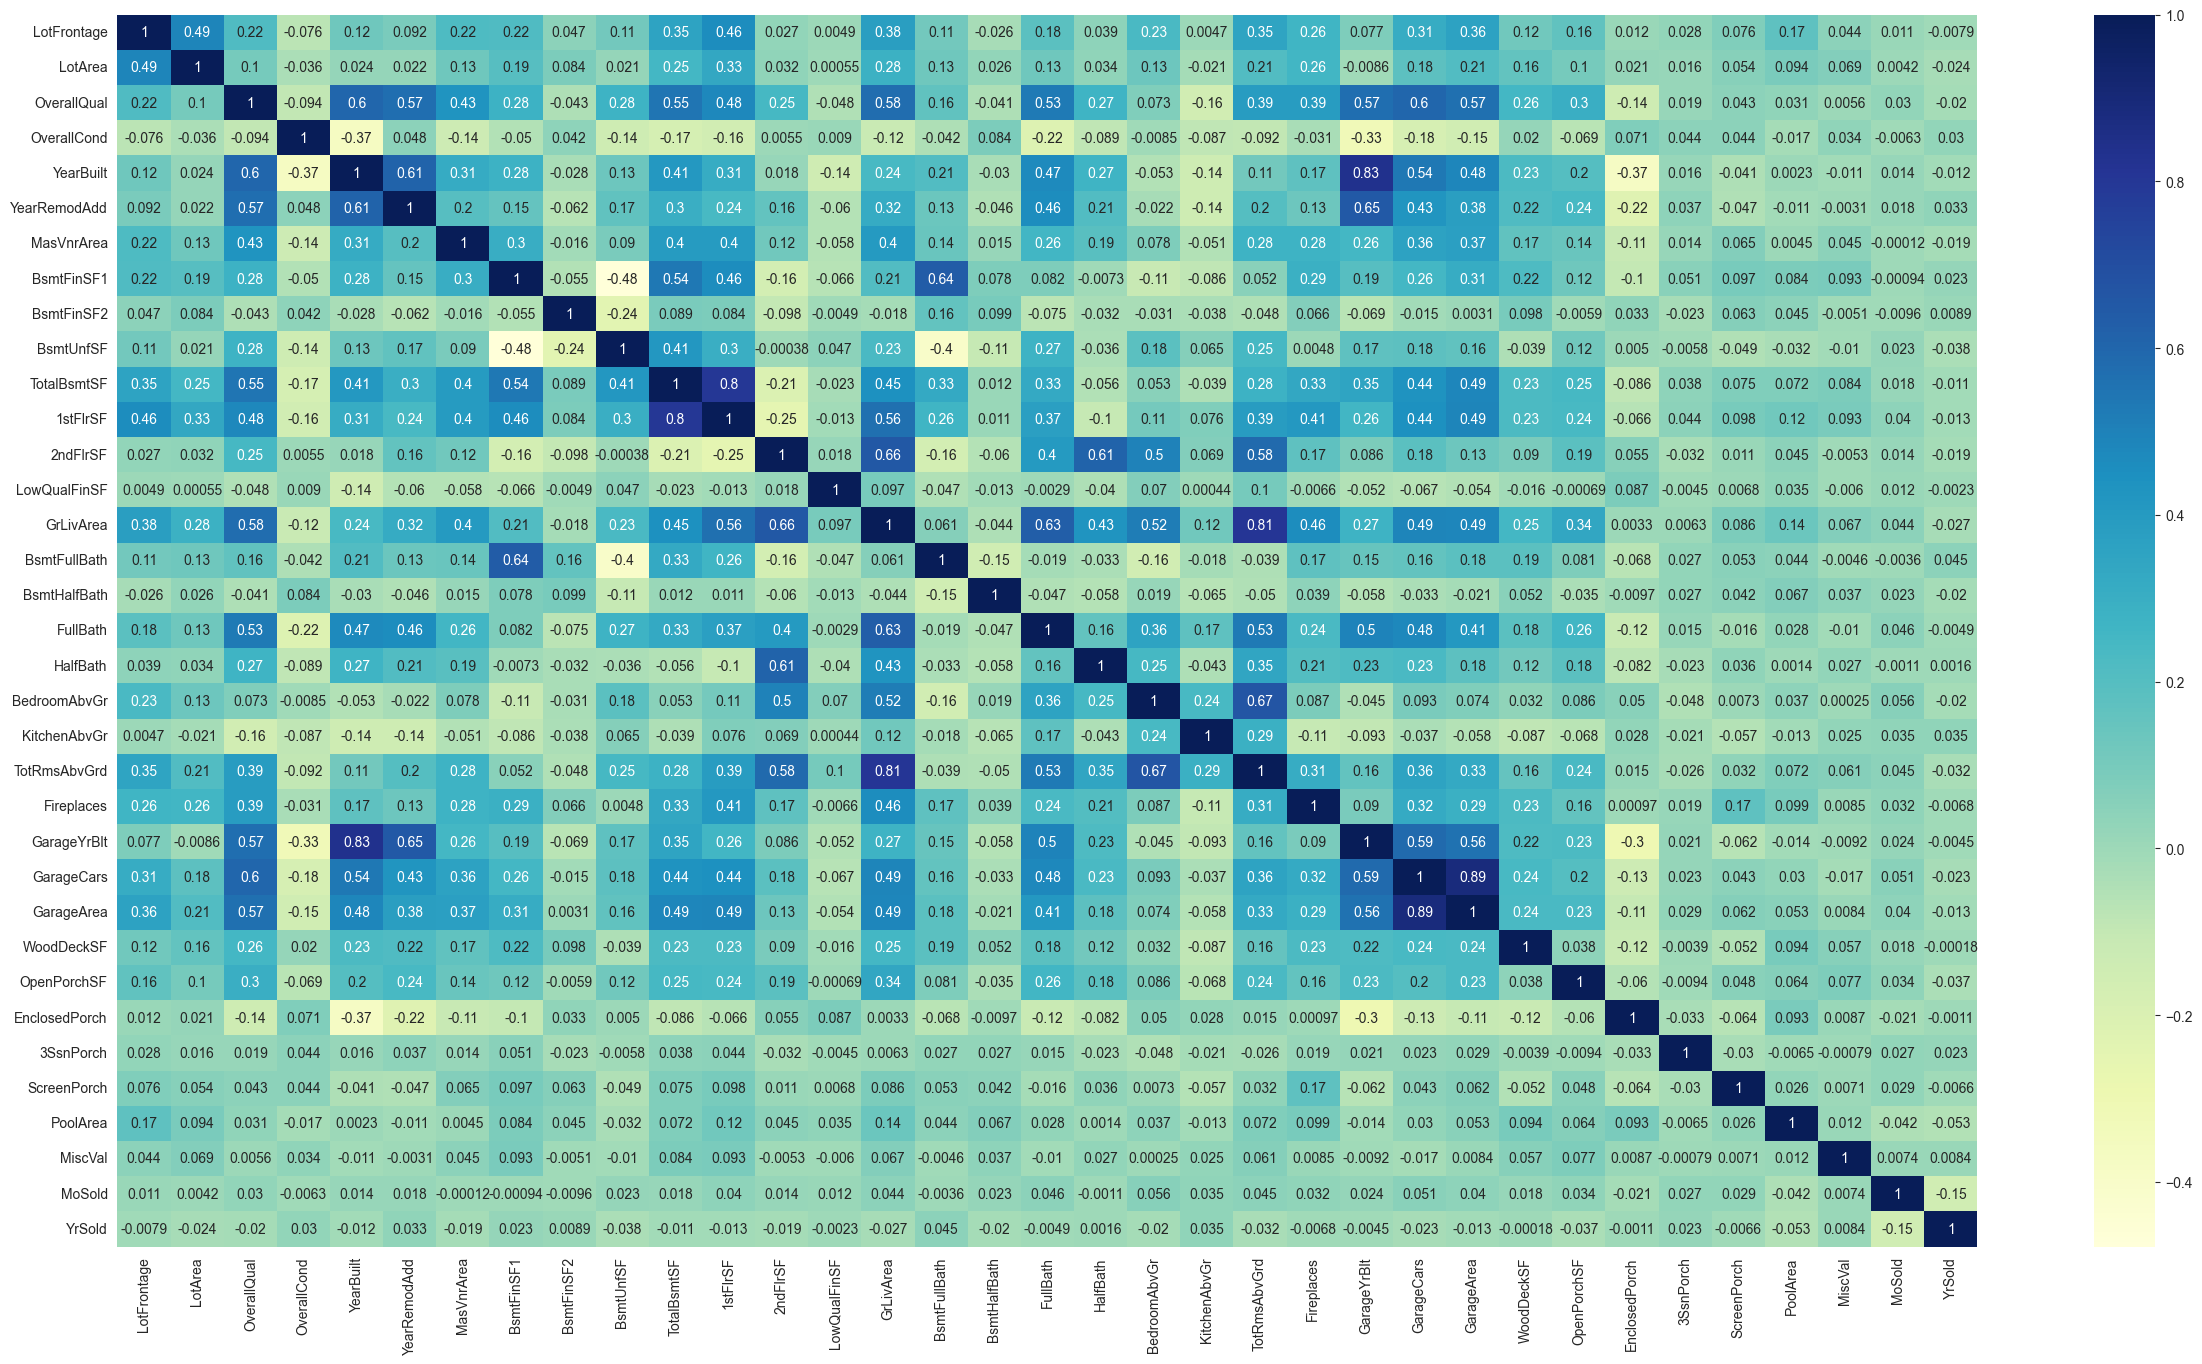

In [17]:
# 绘制热力图
plt.figure(figsize=(30,16))
sns.heatmap(check_related.corr(), annot=True, cmap='YlGnBu')

#### 相关性较强，对于缺失过多的列使用最近邻居的回归算法

In [18]:
# 直接填充缺失值少的列
for column in [
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageCars',
    'GarageArea'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [19]:
data2.select_dtypes(np.number).isnull().sum()[data2.select_dtypes(np.number).isnull().sum() > 0]

LotFrontage    486
MasVnrArea      23
GarageYrBlt    159
dtype: int64

In [20]:
# 根据数据之间的相似度来进行预测，填充空值 

# 定义函数
def knn_impute(df, na_column):
    df = df.copy()
    
    num_df = df.select_dtypes(np.number)
    non_na_columns = num_df.loc[: ,num_df.isna().sum() == 0].columns
    
    y_train = num_df.loc[num_df[na_column].isna() == False, na_column]
    X_train = num_df.loc[num_df[na_column].isna() == False, non_na_columns]
    X_test = num_df.loc[num_df[na_column].isna() == True, non_na_columns]

    # 训练KNN回归算法模型
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_column].isna() == True, na_column] = y_pred
    
    return df

In [21]:
# 将三列数据填充
for column in [
    'LotFrontage',
    'MasVnrArea',
    'GarageYrBlt'
]:
    data2 = knn_impute(data2, column)

In [22]:
data2.isnull().sum()[data2.isnull().sum()>0]

Series([], dtype: int64)

## 进行特征转换

In [23]:
data3 = data2.copy()

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'Kitc

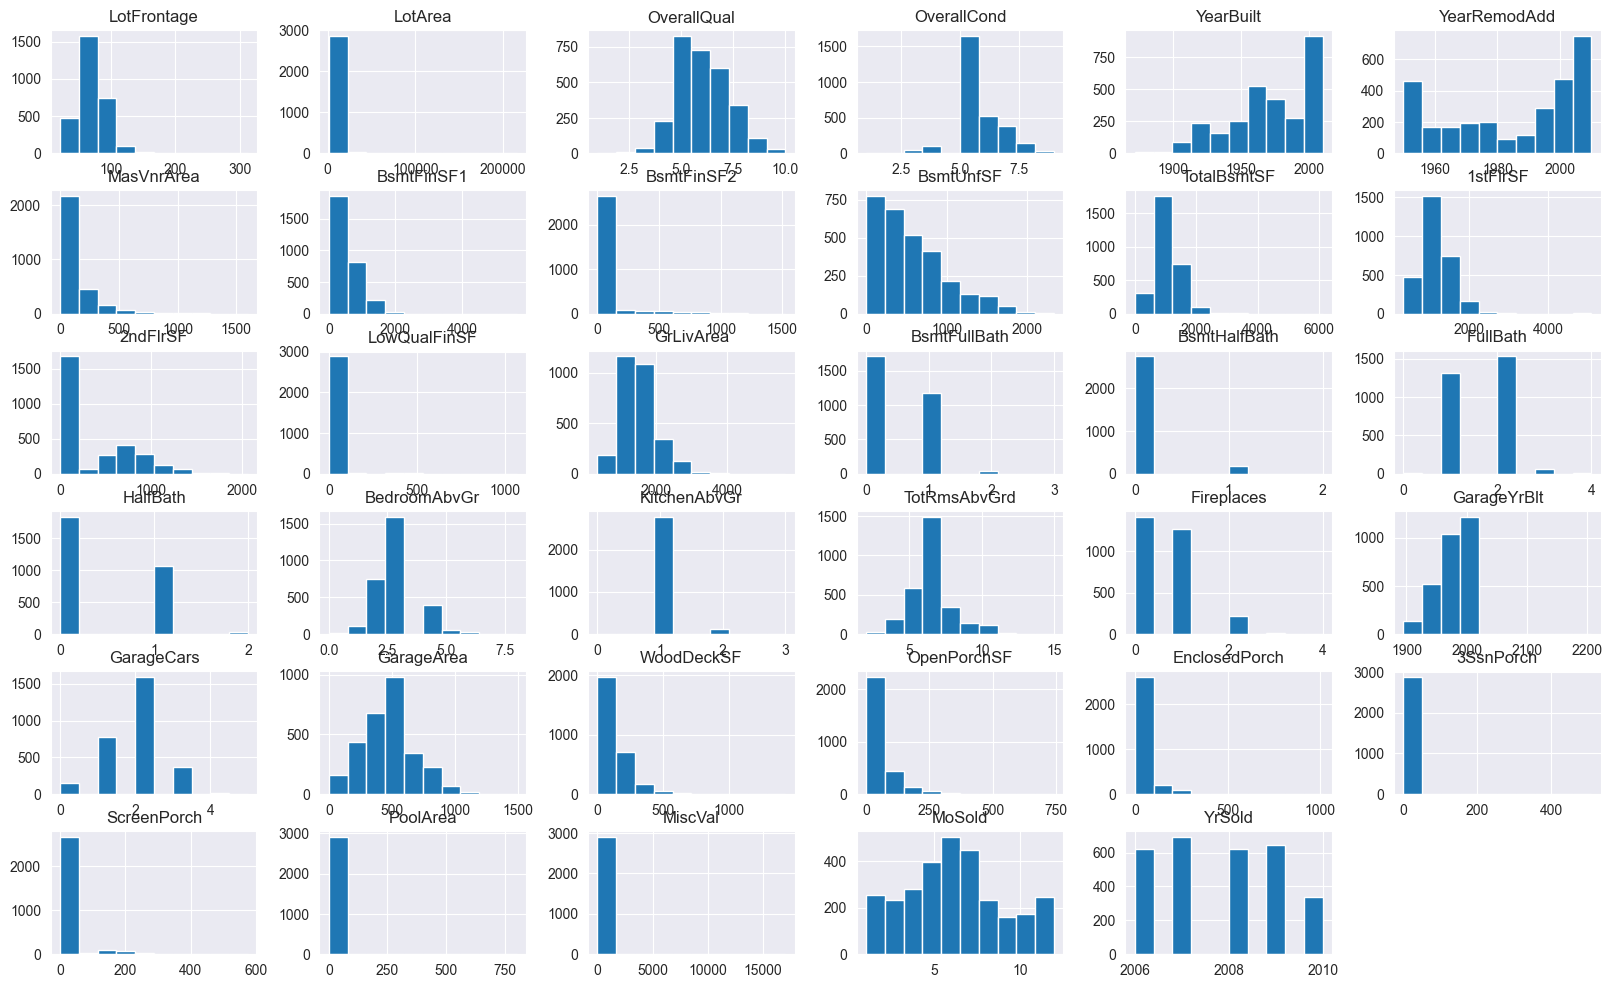

In [24]:
# 简单绘制每个特征值的直方图,观察分布情况  
data3.select_dtypes(np.number).hist(figsize=(20,12))

In [25]:
# 查看数值列的偏度
scipy.stats.skew(data3.select_dtypes(np.number))

array([ 1.35527165, 12.8224314 ,  0.19711045,  0.57031205, -0.59980555,
       -0.45102038,  2.59775257,  1.42523018,  4.14614327,  0.91933923,
        1.15689414,  1.46960442,  0.86167475, 12.088761  ,  1.26935769,
        0.62483211,  3.93159384,  0.16760573,  0.69456649,  0.32632435,
        4.30225437,  0.75836691,  0.7334946 , -0.31839133, -0.21859252,
        0.23925692,  1.84243281,  2.53511373,  4.00389122, 11.37606468,
        3.9466937 , 16.89832792, 21.94719481,  0.19588394,  0.13239881])

In [26]:
# 查看偏度值
def skew_check(df):
    num_df = df.select_dtypes(np.number)
    
    skew = num_df.skew()
    
    skew_thr = 0.5
    
    non_normal_cols = num_df.columns[(np.abs(skew) > skew_thr)].values
    
    return skew

In [27]:
skew_check(data3)

LotFrontage       1.355969
LotArea          12.829025
OverallQual       0.197212
OverallCond       0.570605
YearBuilt        -0.600114
YearRemodAdd     -0.451252
MasVnrArea        2.599088
BsmtFinSF1        1.425963
BsmtFinSF2        4.148275
BsmtUnfSF         0.919812
TotalBsmtSF       1.157489
1stFlrSF          1.470360
2ndFlrSF          0.862118
LowQualFinSF     12.094977
GrLivArea         1.270010
BsmtFullBath      0.625153
BsmtHalfBath      3.933616
FullBath          0.167692
HalfBath          0.694924
BedroomAbvGr      0.326492
KitchenAbvGr      4.304467
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
GarageYrBlt      -0.318555
GarageCars       -0.218705
GarageArea        0.239380
WoodDeckSF        1.843380
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
MoSold            0.195985
YrSold            0.132467
dtype: float64

In [28]:
# 修改偏度值
def skew_change(df):
    num_df = df.select_dtypes(np.number)
    
    skew = num_df.skew()
    
    skew_thr = 0.5
    
    non_normal_cols = num_df.columns[(np.abs(skew) > skew_thr)].values
    
    for column in non_normal_cols:
        data3[column] = np.log1p(data3[column])
    
    return df

In [29]:
skew_change(data3).head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,4.189655,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal
1,20,RL,4.394449,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal
2,60,RL,4.234107,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal
3,70,RL,4.110874,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml
4,60,RL,4.442651,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal


In [30]:
# 再次检验
skew_check(data3).sort_values(ascending=False)

PoolArea         15.006047
3SsnPorch         8.829794
LowQualFinSF      8.562091
MiscVal           5.216665
BsmtHalfBath      3.776703
KitchenAbvGr      3.522161
ScreenPorch       2.947420
BsmtFinSF2        2.463749
EnclosedPorch     1.962089
HalfBath          0.580990
MasVnrArea        0.510723
BsmtFullBath      0.425385
BedroomAbvGr      0.326492
2ndFlrSF          0.305206
GarageArea        0.239380
Fireplaces        0.237710
OverallQual       0.197212
MoSold            0.195985
FullBath          0.167692
WoodDeckSF        0.158114
YrSold            0.132467
1stFlrSF          0.064861
TotRmsAbvGrd      0.035125
GrLivArea         0.013194
OpenPorchSF      -0.041819
GarageCars       -0.218705
GarageYrBlt      -0.318555
YearRemodAdd     -0.451252
LotArea          -0.505010
BsmtFinSF1       -0.616949
YearBuilt        -0.626537
OverallCond      -0.746567
LotFrontage      -0.936612
BsmtUnfSF        -2.156314
TotalBsmtSF      -4.958842
dtype: float64

In [31]:
# 检查最大偏度值列，属实
data3['PoolArea'].value_counts()

PoolArea
0.000000    2906
6.240276       1
6.475433       1
6.357842       1
6.320768       1
6.175867       1
6.253829       1
6.605298       1
4.976734       1
5.910797       1
6.098074       1
5.433722       1
6.331502       1
6.685861       1
Name: count, dtype: int64

## 数据处理完毕，开始进行特征转换 feature transformation

In [32]:
data4 = data3.copy()

In [33]:
data4 = pd.get_dummies(data4)
data4

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,7.602900,2003,5.283204,6.561031,0.0,5.017280,...,False,False,False,True,False,False,False,False,True,False
1,4.394449,9.169623,6,2.197225,7.589336,1976,0.000000,6.886532,0.0,5.652489,...,False,False,False,True,False,False,False,False,True,False
2,4.234107,9.328212,7,1.791759,7.601902,2002,5.093750,6.188264,0.0,6.075346,...,False,False,False,True,False,False,False,False,True,False
3,4.110874,9.164401,7,1.791759,7.557995,1970,0.000000,5.379897,0.0,6.293419,...,False,False,False,True,True,False,False,False,False,False
4,4.442651,9.565284,8,1.791759,7.601402,2000,5.860786,6.486161,0.0,6.196444,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.091042,7.568896,4,2.079442,7.586296,1970,0.000000,0.000000,0.0,6.304449,...,False,False,False,True,False,False,False,False,True,False
2915,3.091042,7.546974,4,1.791759,7.586296,1970,0.000000,5.533389,0.0,5.686975,...,False,False,False,True,True,False,False,False,False,False
2916,5.081404,9.903538,5,2.079442,7.581210,1996,0.000000,7.110696,0.0,0.000000,...,False,False,False,True,True,False,False,False,False,False
2917,4.143135,9.253591,5,1.791759,7.597396,1992,0.000000,5.823046,0.0,6.356108,...,False,False,False,True,False,False,False,False,True,False


## 数据缩放

In [34]:
scaler = StandardScaler()

scaler.fit(data4)

data4 = pd.DataFrame(scaler.transform(data4), index=data4.index, columns=data4.columns)
data4

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.060039,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.208428,0.783568,-0.362565,-0.325268,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.541790,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804094,0.892748,-0.362565,0.014591,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.070592,0.457629,0.646183,-0.435439,0.975922,0.848965,1.136260,0.658535,-0.362565,0.240834,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.291552,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804094,0.387392,-0.362565,0.357511,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.683441,0.922662,1.355551,-0.435439,0.943542,0.753229,1.428445,0.758455,-0.362565,0.305626,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.288528,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804094,-1.417138,-0.362565,0.363412,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.288528,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804094,0.438876,-0.362565,0.033042,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.560544,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804094,0.967937,-0.362565,-3.009689,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.196747,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804094,0.536033,-0.362565,0.391051,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


## target transformation

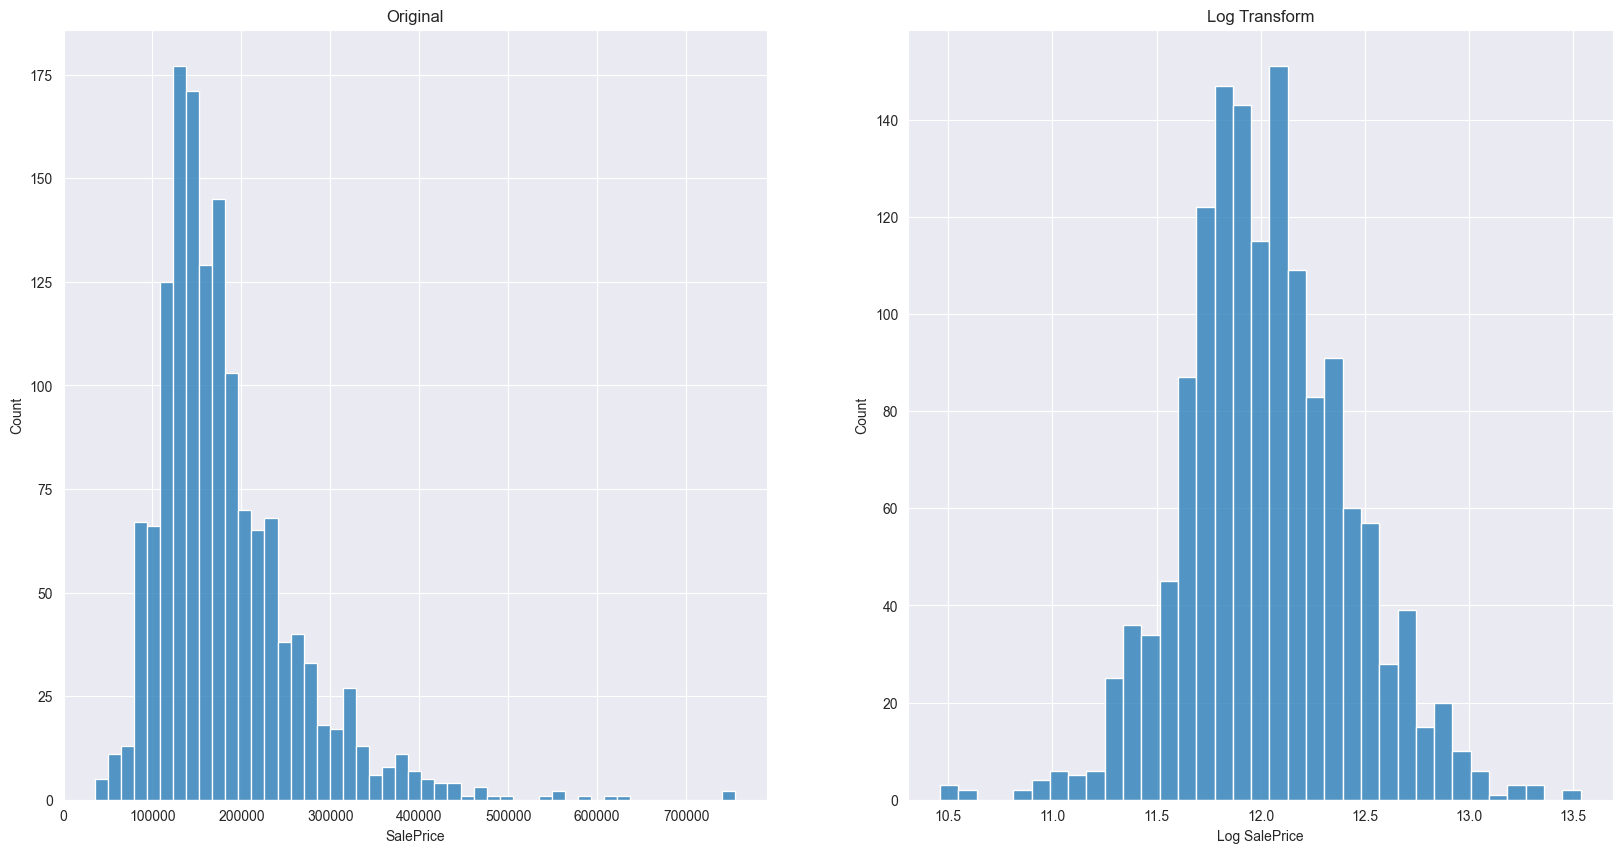

In [35]:
# 探索目标列的特征,进行正态拟合
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(target)
plt.title('Original')

plt.subplot(1,2,2)
sns.histplot(np.log(target))
plt.xlabel('Log SalePrice')
plt.title('Log Transform')

plt.show()

In [36]:
log_target = np.log(target)

## 还原官方训练集和测试集数据

In [37]:
# 训练集
data4.loc[:train0.index.max(), :]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.060039,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.208428,0.783568,-0.362565,-0.325268,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.541790,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804094,0.892748,-0.362565,0.014591,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.070592,0.457629,0.646183,-0.435439,0.975922,0.848965,1.136260,0.658535,-0.362565,0.240834,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.291552,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804094,0.387392,-0.362565,0.357511,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.683441,0.922662,1.355551,-0.435439,0.943542,0.753229,1.428445,0.758455,-0.362565,0.305626,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.196747,-0.231508,-0.063185,-0.435439,0.911146,0.753229,-0.804094,-1.417138,-0.362565,0.661007,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1456,0.717813,0.767440,-0.063185,0.454875,0.227056,0.178812,1.019597,0.821225,2.352717,0.403900,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1457,-0.015847,0.029092,0.646183,2.514892,-0.996100,1.040437,-0.804094,0.468061,-0.362565,0.616590,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1458,0.070592,0.170303,-0.772552,0.454875,-0.696444,0.561757,-0.804094,-0.104964,3.331015,-3.009689,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [38]:
#测试集
data4.loc[train0.index.max()+1: , :]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,0.541790,0.521437,-0.772552,0.454875,-0.332070,-1.113625,-0.804094,0.645902,2.287158,-0.012359,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1461,0.577848,0.923625,-0.063185,0.454875,-0.431241,-1.257229,0.982973,0.873354,-0.362565,0.205237,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1462,0.315625,0.862607,-0.772552,-0.435439,0.846305,0.657493,-0.804094,0.821649,-0.362565,-0.373436,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1463,0.468319,0.222291,-0.063185,0.454875,0.878733,0.657493,0.355651,0.730198,-0.362565,0.084860,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1464,-1.251578,-1.130892,1.355551,-0.435439,0.683917,0.370284,-0.804094,0.453151,-0.362565,0.695747,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.288528,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804094,-1.417138,-0.362565,0.363412,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.288528,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804094,0.438876,-0.362565,0.033042,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.560544,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804094,0.967937,-0.362565,-3.009689,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.196747,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804094,0.536033,-0.362565,0.391051,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [41]:
train_data = data4.loc[:train0.index.max(), :].copy()
test_data = data4.loc[train0.index.max()+1: , :].reset_index(drop=True).copy()

# 选择模型

In [46]:
X = train_data
y = log_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 316), (1168,), (292, 316), (292,))

In [49]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

reg.score(X_test, y_test)

-4.361070366094712e+20

In [50]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train)

forest.score(X_test, y_test)

0.8671011177097532

## 训练模型

In [54]:
model = CatBoostRegressor(verbose=0)

model.fit(X, y)

In [56]:
predictions = np.exp(model.predict(test_data))

# 提交

In [57]:
submission = pd.read_csv('house_prices/sample_submission.csv')
submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [59]:
pred_submission = pd.concat([test_ids, pd.Series(predictions, name='SalePrice')], axis=1)
pred_submission.to_csv("house_prices/My_submission.csv", index=False)

# 最终提交成绩：0.12577
# 名次：714；排名15%